In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import music21 
from midi2audio import FluidSynth
import pickle
import os
import csv
import IPython.display as ipd
import librosa.display

**Pitch Extraction**

In [3]:
def unpickler(path):
    if os.path.getsize(path) > 0:      
        with open(path, "rb") as f:
            unpickler = pickle.Unpickler(f)
            # if file is not empty scores will be equal
            # to the value unpickled
            scores = unpickler.load()
    return scores        

In [5]:
from music21 import features, converter, note, chord

In [9]:
def file_path(path):
    for files in os.walk(path):
        composer_path = [path+midi_files for composer_path in files[2:] for midi_files in composer_path] 
    composer_wav = [composer.replace('composers', 'audio_files').replace('mid', 'wav') for composer in composer_path]
    return composer_path, composer_wav

In [10]:
chopin_path, chopin_wav = file_path('composers/chopin/')
bach_path, bach_wav = file_path('composers/bach/')
beethoven_path, beethoven_wav = file_path('composers/beethoven/')
brahms_path, brahms_wav = file_path('composers/brahms/')
liszt_path, liszt_wav = file_path('composers/liszt/')
mozart_path, mozart_wav = file_path('composers/mozart/')
scarlatti_path, scarlatti_wav = file_path('composers/scarlatti/')
debussy_path, debussy_wav = file_path('composers/debussy/')
tchaikovsky_path, tchaikovsky_wav = file_path('composers/tchaikovsky/')
haydn_path, haydn_wav = file_path('composers/haydn/')

**Convert into Music21 Streams/Objects**

In [ ]:
from music21 import features, converter, note, chord

In [33]:
def stream_converter(midi_files): #convert the midi files into music21 streams
    stream = []
    for midi in midi_files:
        try:
            mf = music21.midi.MidiFile()
            mf.open(midi)
            mf.read()
            mf.close()
            s = music21.midi.translate.midiFileToStream(mf)
            stream.append(s)
        except:
            pass
        
    return stream

In [96]:
chopin = stream_converter(chopin_path)
bach = stream_converter(bach_path)
brahms = stream_converter(brahms_path)
beethoven = stream_converter(beethoven_path)
liszt = stream_converter(liszt_path)
mozart = stream_converter(mozart_path)
debussy = stream_converter(debussy_path)
scarlatti = stream_converter(scarlatti_path)
haydn = stream_converter(haydn_path)
tchaikovsky = stream_converter(tchaikovsky_path)

In [3]:
def get_notes(music21_stream):
    notes = []
    for element in music21_stream:
        piece = []
        notes_in_a_piece = element.flat.notes #extract the notes in a piece
        for i in range(0, len(notes_in_a_piece)):
            if isinstance(notes_in_a_piece[i], note.Note): #differentiate between notes and chords in the piece
                piece.append(str(notes_in_a_piece[i].pitch)) #append the notes
            else:
                piece.append(str(notes_in_a_piece[i]).strip('<music21.chord.Chord').strip('>').split()) #append the chords
        notes.append(piece)
    
    return notes

def flat_to_sharp(music21_stream, composer):
    flat_to_sharp = {'A-': 'G#', 'B-': 'A#', 'C-': 'B', 'D-': 'A#', 'E-': 'D#', 'F-': 'E', 'G-': 'F#', 'C#-': 'C#',
                    'E-0': 'D#1', 'A-0': 'G#1'} 
    
    composer_notes = get_notes(music21_stream)
    
    modified_notes = []
    for composition in composer_notes:
        notes_in_a_piece = []
        for notes in composition:
            if type(notes) == str and '-' in notes: 
                notes_in_a_piece.append([notes.replace(notes[:-1], flat_to_sharp[notes[:-1]])])
            elif type(notes) == list:
                notes_in_a_chord = []
                for chord in notes:
                    if '-' in chord:
                        notes_in_a_chord.append(chord.replace(chord[:-1], flat_to_sharp[chord[:-1]]))
                    else:
                        notes_in_a_chord.append(chord)
                notes_in_a_piece.append(notes_in_a_chord)
            else:
                notes_in_a_piece.append([notes])
        modified_notes.append(notes_in_a_piece)
        
    file = open('modified_notes/{}.obj'.format(composer), 'wb')
    pickle.dump(modified_notes, file)
    
    return modified_notes

There are many ways I can do the feature mapping of the pieces but the best way I thought of was to map the notes out in a way that resembles a piano, which would leave me with a column space of 88. Therefore, I have decided to change the flats to sharps so that we are left with 12 chroma across 8 octaves. This should reduce the variance in the model later on.

In [4]:
#open the pickled files that contain the modified notes
chopin_notes = unpickler('modified_notes/chopin.obj')
bach_notes = unpickler('modified_notes/bach.obj')
beethoven_notes = unpickler('modified_notes/beethoven.obj')
brahms_notes = unpickler('modified_notes/brahms.obj')
liszt_notes = unpickler('modified_notes/liszt.obj')
mozart_notes = unpickler('modified_notes/mozart.obj')
scarlatti_notes = unpickler('modified_notes/scarlatti.obj')
debussy_notes = unpickler('modified_notes/debussy.obj')
haydn_notes = unpickler('modified_notes/haydn.obj')
tchaikovsky_notes = unpickler('modified_notes/tchaikovsky.obj')

In [5]:
keys = list(set([notes[0] for piece in debussy_notes for notes in piece if len(notes) < 2])) #unique notes
keys = keys + ['B7', 'C8'] #the note B7 and C8 are the only two missing notes
keys = sorted(keys)
len(keys)

88

Instead of manually creating the feature space ourselves, we can use the number of unique notes by the composers and add on the missing notes to create the full feature map. It appears that Debussy used 86 unique notes throughot his pieces and was missing B7 and C8.

In [6]:
def sequence_mapper(composer_notes, sequence_length):
    sequence = [piece[i:i+sequence_length] for piece in composer_notes
               for i in range(0, len(piece), sequence_length)
                if len(piece[i:i+sequence_length]) == sequence_length
               ] #split the sequence of notes into a certain lengths
    return sequence

def one_hot_encoder(composer_notes, sequence_length):
    mlb = MultiLabelBinarizer() #map the notes into numerical format 
    composer_sequence = sequence_mapper(composer_notes, sequence_length) #calll the function above
    
    one_hot_sequence = []
    for sequence in composer_sequence:
        sequence = sequence + list([keys])
        one_hot_sequence.append(np.delete(mlb.fit_transform(sequence), -1, axis=0)) #remove the keys from the tensor
    
    return np.array(one_hot_sequence)

For the same reasons as the CNN, I have decided to split the notes into sequences of length 100, in order to create more data for the LSTM model. After I do this, I can then one-hot encode the notes so that they are in a numerical format. This means that rows that have a single 1 indicate 1 note is being played and rows with multiple 1's indicate a chord is being played and therefore I am not losing any information on the piece.

In [9]:
#c_sequence = one_hot_encoder(chopin_notes, 100)
b_sequence = one_hot_encoder(bach_notes, 100)
be_sequence = one_hot_encoder(beethoven_notes, 100)
#br_sequence = one_hot_encoder(brahms_notes, 100)
l_sequence = one_hot_encoder(liszt_notes, 100)
#m_sequence = one_hot_encoder(mozart_notes, 100)
s_sequence = one_hot_encoder(scarlatti_notes, 100)
d_sequence = one_hot_encoder(debussy_notes, 100)
h_sequence = one_hot_encoder(haydn_notes, 100)
t_sequence = one_hot_encoder(tchaikovsky_notes, 100)

In [10]:
b_sequence.shape

(1212, 100, 88)

**Debugging**

For three of the composers, there seems to be a problem with the onehot encoder function I wrote above so I have decided to debug them and find out what's happening

In [11]:
def one_hot_encoder_debug(composer_notes, sequence_length):
    mlb = MultiLabelBinarizer()
    composer_sequence = sequence_mapper(composer_notes, sequence_length)
    
    one_hot_sequence = []
    for sequence in composer_sequence:
        sequence = sequence + list([keys])
        one_hot_sequence.append(np.delete(mlb.fit_transform(sequence), -1, axis=0)) #remove the keys from the tensor
    
    return one_hot_sequence

In [12]:
c_debug = one_hot_encoder_debug(chopin_notes, 100)
br_debug = one_hot_encoder_debug(brahms_notes, 100)
m_debug = one_hot_encoder_debug(mozart_notes, 100)

In [13]:
c_seq = sequence_mapper(chopin_notes, 100)
br_seq = sequence_mapper(brahms_notes, 100)
m_seq = sequence_mapper(mozart_notes, 100)

In [35]:
def troublemakers(composer_sequence):
    sequence_number = []
    for i, sequence in enumerate(composer_sequence):
        if sequence.shape[1] != 88:
            sequence_number.append(i)
    
    note = []
    
    return sequence_number #this returns the individual pieces that are causing problems

def wrong_notes(one_hot_sequence, sequence):
    pieces = troublemakers(one_hot_sequence)
    wrong_note = []
    for piece in pieces:
        for note_num, notes in enumerate(sequence[piece]):
            for note in notes:
                if note not in keys:
                    wrong_note.append((piece, note_num, notes, note))
    return wrong_note #this returns the individual notes in the pieces that are causing problems

In [37]:
print('composer: (piece/sequence number, position of note in sequence, note/chord incl. wrong note, wrong note)')
print('chopin: ', wrong_notes(c_debug, c_seq))
print('brahms: ', wrong_notes(br_debug, br_seq))
print('mozart: ', wrong_notes(m_debug, m_seq))

composer: (piece/sequence number, position of note in sequence, note/chord incl. wrong note, wrong note)
chopin:  [(1181, 53, ['D#6', 'D#0', 'D#5', 'D#1'], 'D#0'), (1462, 9, ['G#0', 'A#1'], 'G#0')]
brahms:  [(441, 46, ['F#0'], 'F#0'), (517, 81, ['F#1', 'F0'], 'F0')]
mozart:  [(751, 56, ['G0', 'G1', 'G2'], 'G0'), (752, 10, ['F0', 'F2', 'F1'], 'F0')]


In [38]:
#chopin
c_seq[1181][53][1] = c_seq[1181][53][1].replace('0', '2') #replace with 2, which is an octave up with D#1
c_seq[1462][9][0] = c_seq[1462][9][0].replace('0', '1') 

#brahms
br_seq[441][46][0] = br_seq[441][46][0].replace('0', '1')
br_seq[517][81][1] = br_seq[441][46][0].replace('0', '1')

#mozart
m_seq[751][56][0] = m_seq[751][56][0].replace('0', '3') #looks like the notes in the chord are an octave apart so it makes sense to change the 0 to a 3
m_seq[752][10][0] = m_seq[752][10][0].replace('0', '3')

Therein lies the problem: G0, F0, etc are not actual notes on a piano and therefore I have assumed that the person who made the midi files intended to keep the chord one octave apart.

In [39]:
c_sequence = one_hot_encoder(c_seq, 100) #use original function to see if it works
br_sequence = one_hot_encoder(br_seq, 100)
m_sequence = one_hot_encoder(m_seq, 100)

**Create X and Y Tensors**

The below cell will duplicate a composer's name by the number of sequences and turn them into a numpy array, which also has to be onehot encoded.

In [143]:
labels = [['chopin']*c_sequence.shape[0], ['bach']*b_sequence.shape[0], ['beethoven']*be_sequence.shape[0], \
 ['brahms']*br_sequence.shape[0], ['liszt']*l_sequence.shape[0], ['mozart']*m_sequence.shape[0], \
 ['scarlatti']*s_sequence.shape[0], ['debussy']*d_sequence.shape[0], ['haydn']*h_sequence.shape[0], \
 ['tchaikovsky']*t_sequence.shape[0]]

y = np.array([composer for composers in labels for composer in composers]).reshape(-1, 1)

onehot = OneHotEncoder()
Y = onehot.fit_transform(y).toarray()

In [144]:
Y.shape

(16249, 10)

In [147]:
X = np.vstack([c_sequence, b_sequence, be_sequence, br_sequence, l_sequence, \
           m_sequence, s_sequence, d_sequence, h_sequence, t_sequence]) #create the X-tensor e.g. our predictor matrix

In [148]:
X.shape

(16249, 100, 88)

In [151]:
y.shape

(16249, 1)

# **Modelling**

In [159]:
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Input, Dropout, LSTM, GRU, Activation, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.regularizers import l1, l2
from keras import optimizers

Using TensorFlow backend.


In [153]:
pd.Series(y.reshape(-1)).value_counts(normalize=True)

haydn          0.195212
beethoven      0.173857
mozart         0.127208
chopin         0.123146
liszt          0.108868
bach           0.074589
scarlatti      0.064681
brahms         0.057665
debussy        0.049972
tchaikovsky    0.024802
dtype: float64

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=1)

In [161]:
X_train.shape[1:]

(100, 88)

In [170]:
def LSTMModel(input_shape, h_units, activation_f, dropout_prob, learning_rate, metric):
    input_ = Input(shape=input_shape) #defining shape of input
    X = LSTM(h_units, activation=activation_f, return_sequences=False)(input_)
    X = Dropout(dropout_prob)(X)
    X = Dense(10)(X) #output layer - 10 labels for 10 composers
    X = Activation('softmax')(X)
    
    adam = optimizers.Adam(lr=learning_rate)
    
    model = Model(inputs=input_, outputs=X)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = metric)
    return model

In [174]:
def loss_accuracy_plot(hist):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))

    #loss plots
    ax[0].plot(hist.history['loss']) #training loss
    ax[0].plot(hist.history['val_loss']) #validation loss
    ax[0].set_title('Model loss') 
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    
    #accuracy plots
    ax[1].plot(hist.history['acc']) #training accuracy
    ax[1].plot(hist.history['val_acc']) #validation accuracy
    ax[1].set_title('Model Accuracy') 
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='lower right')
    
    fig.tight_layout()
    plt.show()

In [173]:
lstm = LSTMModel(input_shape = X_train.shape[1:], h_units=64, activation_f='sigmoid', dropout_prob=0.2, learning_rate=0.001, metric=['accuracy'])
lstm_hist = lstm.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)

Train on 10399 samples, validate on 2600 samples
Epoch 1/50
10399/10399 [==============================] - 39s 4ms/step - loss: 2.1858 - acc: 0.1868 - val_loss: 2.1539 - val_acc: 0.1923
Epoch 2/50
10399/10399 [==============================] - 39s 4ms/step - loss: 2.1541 - acc: 0.2064 - val_loss: 2.0874 - val_acc: 0.2446
Epoch 3/50
10399/10399 [==============================] - 38s 4ms/step - loss: 1.9986 - acc: 0.2699 - val_loss: 1.9079 - val_acc: 0.2865
Epoch 4/50
10399/10399 [==============================] - 37s 4ms/step - loss: 1.8939 - acc: 0.2935 - val_loss: 1.8514 - val_acc: 0.3127
Epoch 5/50
10399/10399 [==============================] - 37s 4ms/step - loss: 1.8564 - acc: 0.3128 - val_loss: 1.8278 - val_acc: 0.3219
Epoch 6/50
10399/10399 [==============================] - 37s 4ms/step - loss: 1.8138 - acc: 0.3353 - val_loss: 1.8196 - val_acc: 0.3312
Epoch 7/50
10399/10399 [==============================] - 38s 4ms/step - loss: 1.7724 - acc: 0.3505 - val_loss: 1.7499 - val_acc:

In [175]:
print("Training Accuracy: ", lstm_hist.history["acc"][-1])
print("Validation Accuracy:", lstm_hist.history["val_acc"][-1])
print("Test Accuracy: ", lstm.evaluate(X_test, y_test)[1])

Training Accuracy:  0.5712087700281915
Validation Accuracy: 0.49923076923076926
3250/3250 [==============================] - 2s 711us/step
Test Accuracy:  0.5073846153479356


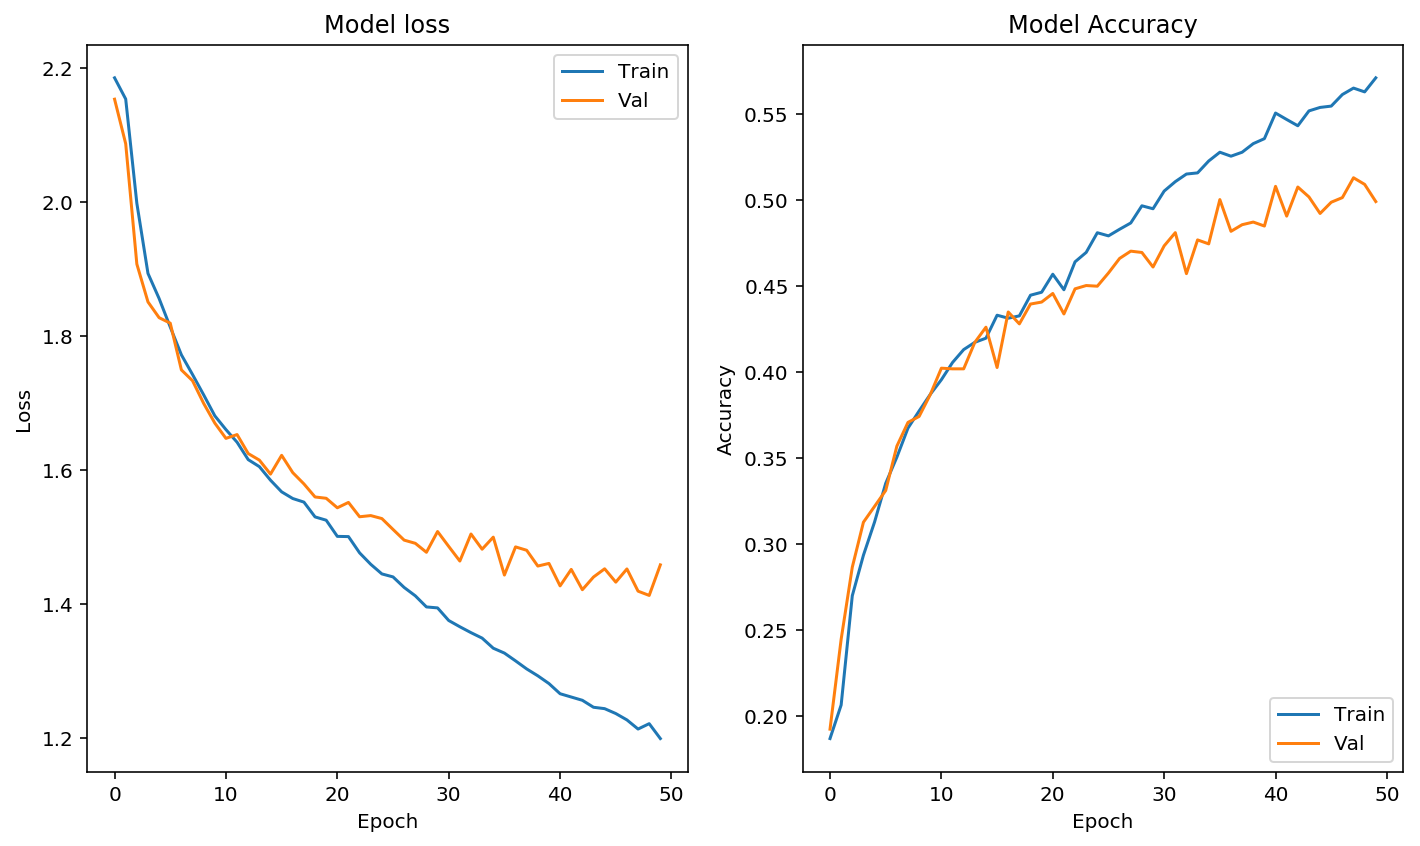

In [176]:
loss_accuracy_plot(lstm_hist)

In [177]:
lstm2 = LSTMModel(input_shape = X_train.shape[1:], h_units=64, activation_f='sigmoid', dropout_prob=0.2, learning_rate=0.001, metric=['accuracy'])
lstm_hist2 = lstm2.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

Train on 10399 samples, validate on 2600 samples
Epoch 1/100
10399/10399 [==============================] - 38s 4ms/step - loss: 2.1857 - acc: 0.1834 - val_loss: 2.1546 - val_acc: 0.1935
Epoch 2/100
10399/10399 [==============================] - 37s 4ms/step - loss: 2.1554 - acc: 0.2101 - val_loss: 2.1087 - val_acc: 0.2462
Epoch 3/100
10399/10399 [==============================] - 36s 3ms/step - loss: 2.0200 - acc: 0.2647 - val_loss: 1.9147 - val_acc: 0.2904
Epoch 4/100
10399/10399 [==============================] - 36s 3ms/step - loss: 1.8989 - acc: 0.2995 - val_loss: 1.8758 - val_acc: 0.3127
Epoch 5/100
10399/10399 [==============================] - 37s 4ms/step - loss: 1.8555 - acc: 0.3192 - val_loss: 1.8273 - val_acc: 0.3165
Epoch 6/100
10399/10399 [==============================] - 40s 4ms/step - loss: 1.8212 - acc: 0.3299 - val_loss: 1.7875 - val_acc: 0.3373
Epoch 7/100
10399/10399 [==============================] - 38s 4ms/step - loss: 1.7840 - acc: 0.3436 - val_loss: 1.7477 - v

In [178]:
print("Training Accuracy: ", lstm_hist2.history["acc"][-1])
print("Validation Accuracy:", lstm_hist2.history["val_acc"][-1])
print("Test Accuracy: ", lstm2.evaluate(X_test, y_test)[1])

Training Accuracy:  0.6630445234602902
Validation Accuracy: 0.47423076923076923
3250/3250 [==============================] - 2s 692us/step
Test Accuracy:  0.5012307693774883


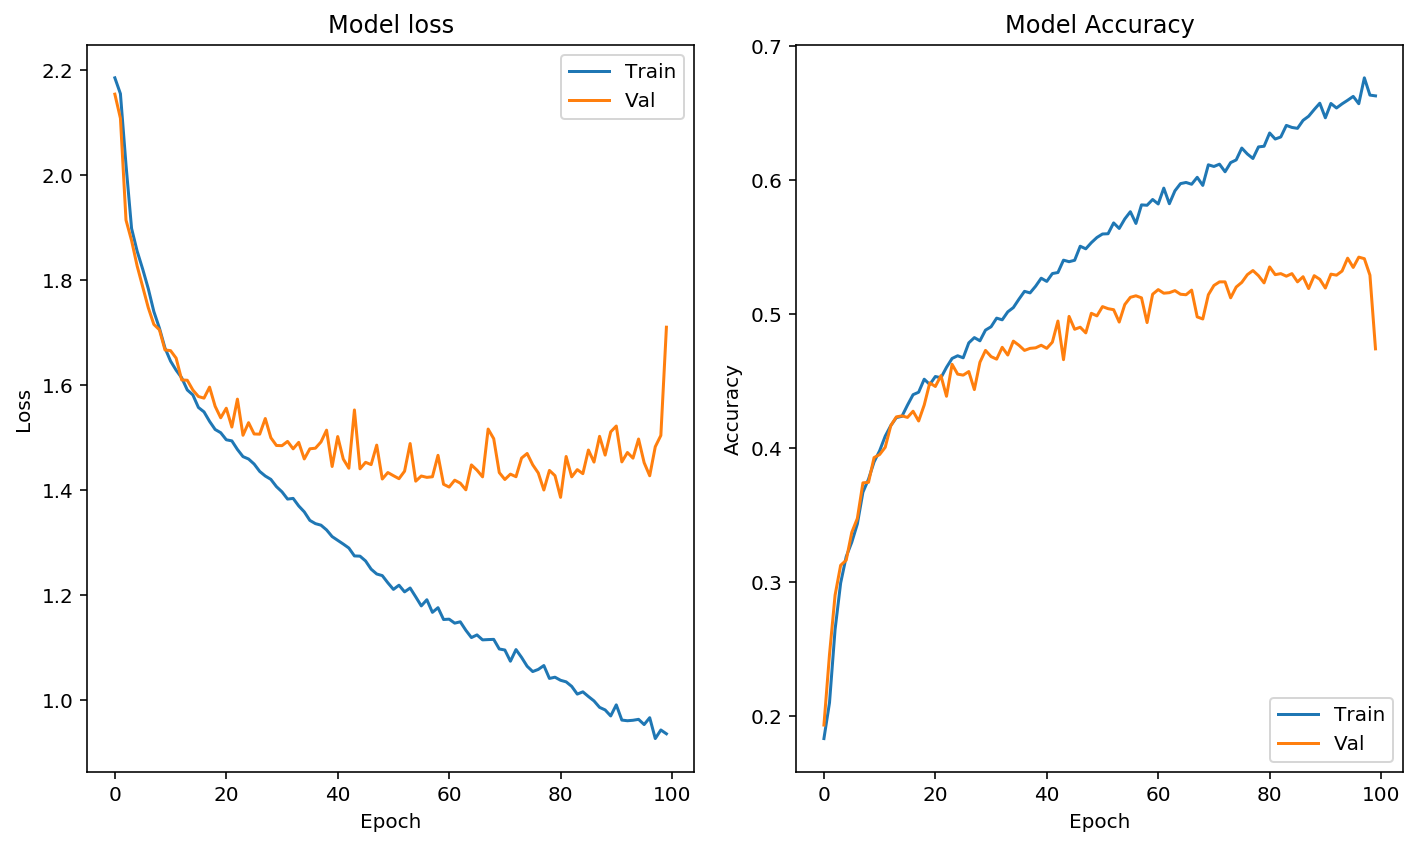

In [180]:
loss_accuracy_plot(lstm_hist2)

In [184]:
lstm3 = LSTMModel(input_shape = X_train.shape[1:], h_units=64, activation_f='sigmoid', dropout_prob=0.5, learning_rate=0.00075, metric=['accuracy'])
lstm_hist3 = lstm3.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

Train on 10399 samples, validate on 2600 samples
Epoch 1/100
10399/10399 [==============================] - 37s 4ms/step - loss: 2.2330 - acc: 0.1647 - val_loss: 2.1590 - val_acc: 0.1885
Epoch 2/100
10399/10399 [==============================] - 35s 3ms/step - loss: 2.1895 - acc: 0.1865 - val_loss: 2.1538 - val_acc: 0.2250
Epoch 3/100
10399/10399 [==============================] - 36s 3ms/step - loss: 2.1723 - acc: 0.1935 - val_loss: 2.1452 - val_acc: 0.2023
Epoch 4/100
10399/10399 [==============================] - 36s 3ms/step - loss: 2.1466 - acc: 0.2080 - val_loss: 2.0939 - val_acc: 0.2431
Epoch 5/100
10399/10399 [==============================] - 36s 3ms/step - loss: 2.0393 - acc: 0.2493 - val_loss: 1.9317 - val_acc: 0.2838
Epoch 6/100
10399/10399 [==============================] - 36s 3ms/step - loss: 1.9356 - acc: 0.2758 - val_loss: 1.8812 - val_acc: 0.2900
Epoch 7/100
10399/10399 [==============================] - 36s 3ms/step - loss: 1.8943 - acc: 0.2954 - val_loss: 1.9040 - v

In [185]:
print("Training Accuracy: ", lstm_hist3.history["acc"][-1])
print("Validation Accuracy:", lstm_hist3.history["val_acc"][-1])
print("Test Accuracy: ", lstm3.evaluate(X_test, y_test)[1])

Training Accuracy:  0.5594768727189108
Validation Accuracy: 0.5023076923076923
3250/3250 [==============================] - 2s 662us/step
Test Accuracy:  0.5058461539561931


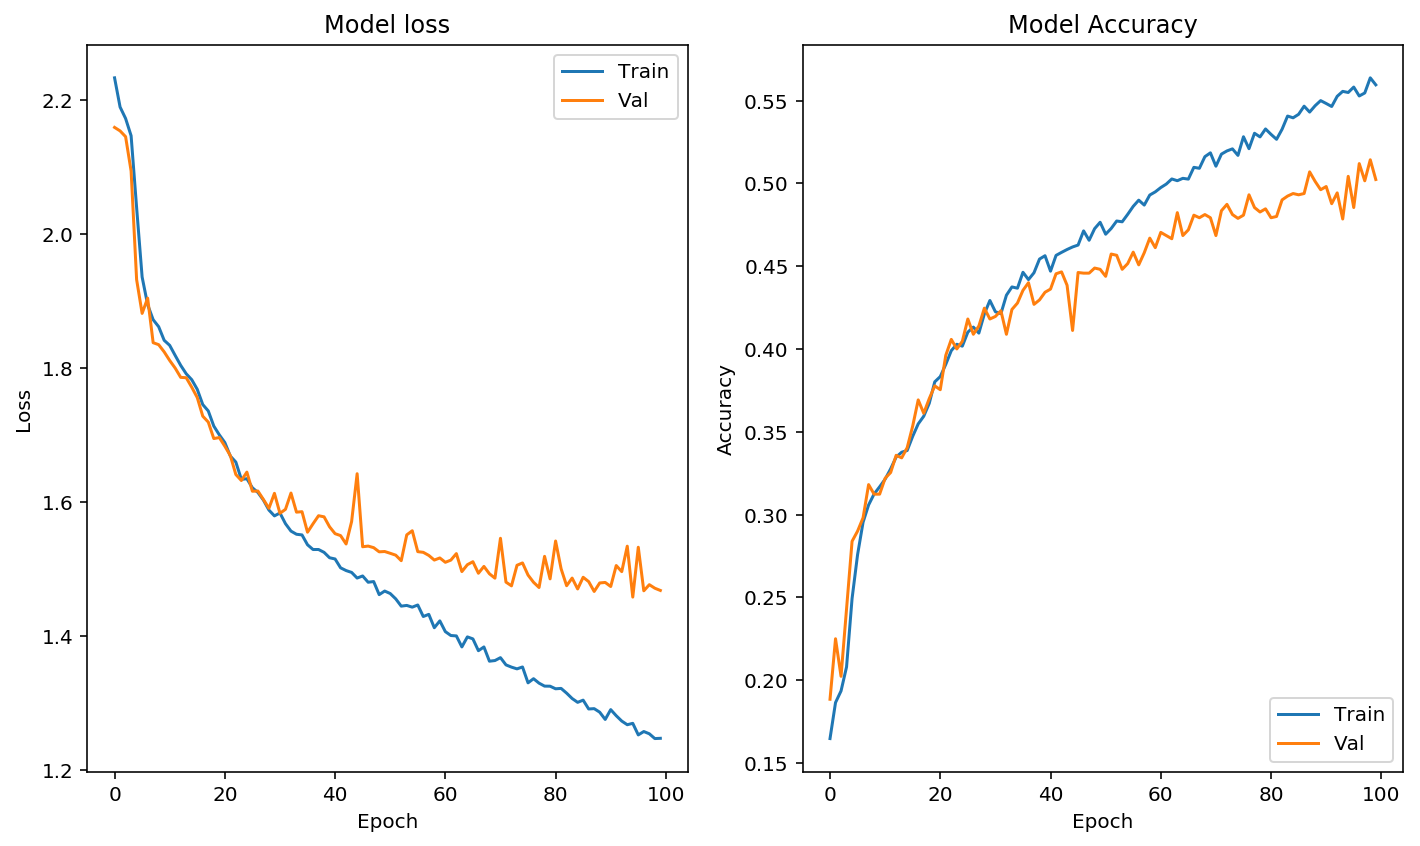

In [186]:
loss_accuracy_plot(lstm_hist3)

We see little improvement across all three models, the loss for the validation set appears to have plateaued after 50 epochs. The maximum accuracy that is obtainable with conventional LSTM models appears to be ~50%.

In [193]:
from keras.layers import Bidirectional
from keras.models import Sequential

In [208]:
def bidirectional_lstm(h_units1, h_units2, shape_input, activation_f, dropout1, dropout2, learning_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(h_units1, activation=activation_f, dropout=dropout1, return_sequences=True),
                        input_shape=shape_input))
    model.add(Bidirectional(LSTM(h_units2, activation=activation_f, dropout=dropout2)))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    optm = optimizers.Adam(lr=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optm, metrics=['accuracy'])
    
    return model

In [211]:
bi_lstm = bidirectional_lstm(h_units1 = 64, h_units2 = 64, shape_input = X_train.shape[1:], activation_f = 'sigmoid', dropout1=0.5, dropout2=0.5, learning_rate=0.00075)
bi_lstm_hist = bi_lstm.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)


Train on 10399 samples, validate on 2600 samples
Epoch 1/100
10399/10399 [==============================] - 99s 10ms/step - loss: 2.1736 - acc: 0.1867 - val_loss: 2.1699 - val_acc: 0.1885
Epoch 2/100
10399/10399 [==============================] - 88s 8ms/step - loss: 2.1673 - acc: 0.1902 - val_loss: 2.1628 - val_acc: 0.1885
Epoch 3/100
10399/10399 [==============================] - 87s 8ms/step - loss: 2.1597 - acc: 0.1942 - val_loss: 2.1109 - val_acc: 0.2481
Epoch 4/100
10399/10399 [==============================] - 91s 9ms/step - loss: 2.0118 - acc: 0.2569 - val_loss: 1.9064 - val_acc: 0.2827
Epoch 5/100
10399/10399 [==============================] - 90s 9ms/step - loss: 1.9197 - acc: 0.2873 - val_loss: 1.8817 - val_acc: 0.3012
Epoch 6/100
10399/10399 [==============================] - 88s 8ms/step - loss: 1.8854 - acc: 0.3084 - val_loss: 1.8944 - val_acc: 0.3085
Epoch 7/100
10399/10399 [==============================] - 87s 8ms/step - loss: 1.8584 - acc: 0.3187 - val_loss: 1.8240 - 

In [212]:
print("Training Accuracy: ", bi_lstm_hist.history["acc"][-1])
print("Validation Accuracy:", bi_lstm_hist.history["val_acc"][-1])
print("Test Accuracy: ", bi_lstm.evaluate(X_test, y_test)[1])

Training Accuracy:  0.4782190595650767
Validation Accuracy: 0.4423076923076923
3250/3250 [==============================] - 6s 2ms/step
Test Accuracy:  0.45200000014671915


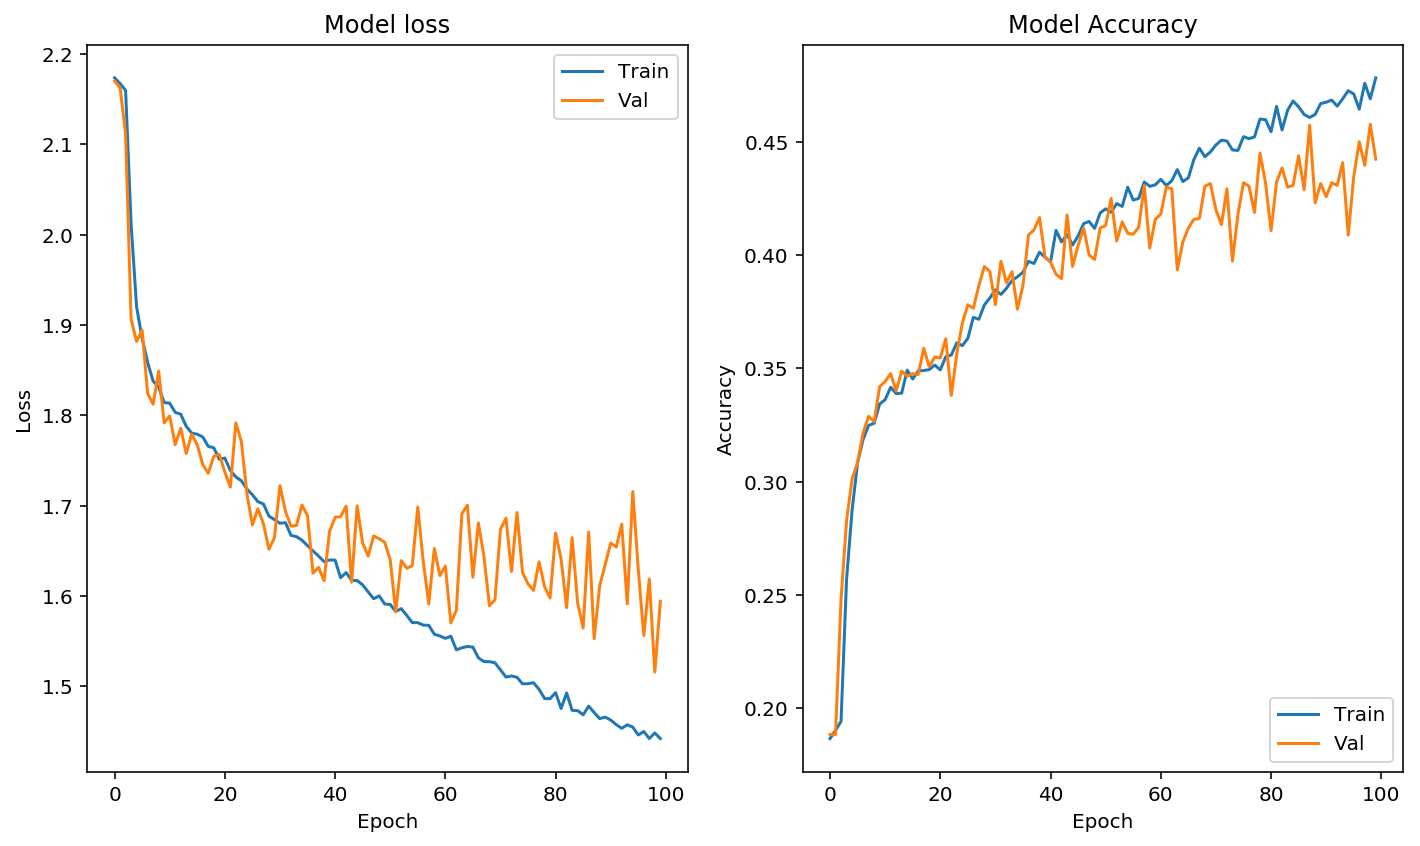

In [213]:
loss_accuracy_plot(bi_lstm_hist)

In [215]:
bi_lstm2 = bidirectional_lstm(h_units1 = 64, h_units2 = 64, shape_input = X_train.shape[1:], activation_f = 'tanh', dropout1=0.5, dropout2=0.5, learning_rate=0.00075)
bi_lstm_hist2 = bi_lstm2.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2)


Train on 10399 samples, validate on 2600 samples
Epoch 1/50
10399/10399 [==============================] - 96s 9ms/step - loss: 2.0312 - acc: 0.2575 - val_loss: 1.8647 - val_acc: 0.3069
Epoch 2/50
10399/10399 [==============================] - 87s 8ms/step - loss: 1.8638 - acc: 0.3180 - val_loss: 1.8625 - val_acc: 0.3273
Epoch 3/50
10399/10399 [==============================] - 88s 8ms/step - loss: 1.8168 - acc: 0.3366 - val_loss: 1.7383 - val_acc: 0.3627
Epoch 4/50
10399/10399 [==============================] - 87s 8ms/step - loss: 1.7837 - acc: 0.3467 - val_loss: 1.6952 - val_acc: 0.3762
Epoch 5/50
10399/10399 [==============================] - 87s 8ms/step - loss: 1.7598 - acc: 0.3521 - val_loss: 1.6869 - val_acc: 0.3892
Epoch 6/50
10399/10399 [==============================] - 87s 8ms/step - loss: 1.7433 - acc: 0.3611 - val_loss: 1.7222 - val_acc: 0.3827
Epoch 7/50
10399/10399 [==============================] - 88s 8ms/step - loss: 1.7359 - acc: 0.3665 - val_loss: 1.6714 - val_acc:

In [216]:
print("Training Accuracy: ", bi_lstm_hist2.history["acc"][-1])
print("Validation Accuracy:", bi_lstm_hist2.history["val_acc"][-1])
print("Test Accuracy: ", bi_lstm2.evaluate(X_test, y_test)[1])

Training Accuracy:  0.5089912491815
Validation Accuracy: 0.5096153846153846
3250/3250 [==============================] - 6s 2ms/step
Test Accuracy:  0.5163076922710125


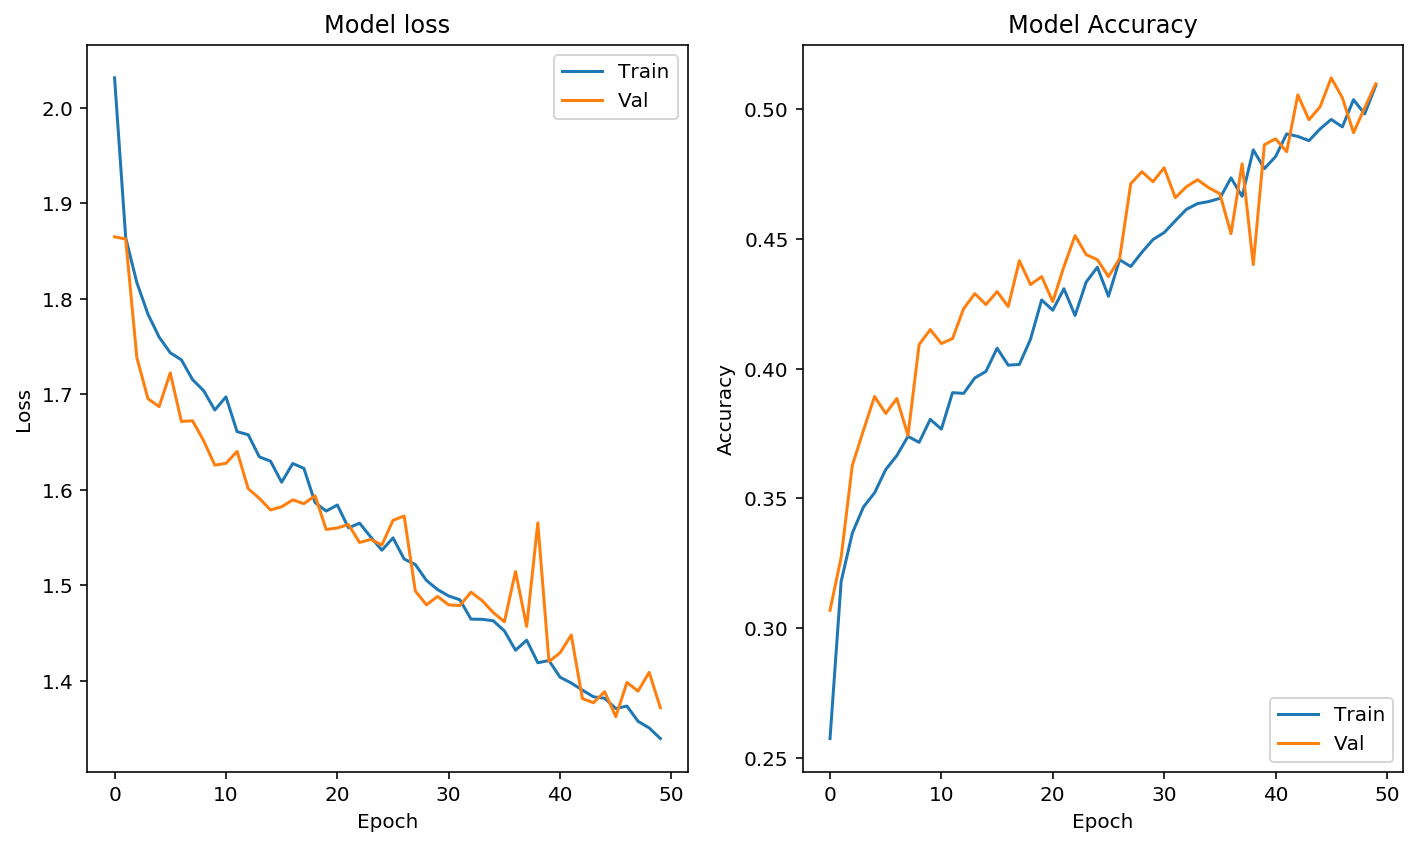

In [218]:
loss_accuracy_plot(bi_lstm_hist2)

In [220]:
bi_lstm3 = bidirectional_lstm(h_units1 = 32, h_units2 = 32, shape_input = X_train.shape[1:], activation_f = 'tanh', dropout1=0.3, dropout2=0.3, learning_rate=0.00075)
bi_lstm_hist3 = bi_lstm3.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)


Train on 10399 samples, validate on 2600 samples
Epoch 1/100
10399/10399 [==============================] - 92s 9ms/step - loss: 2.0191 - acc: 0.2540 - val_loss: 1.8791 - val_acc: 0.3154
Epoch 2/100
10399/10399 [==============================] - 81s 8ms/step - loss: 1.8532 - acc: 0.3223 - val_loss: 1.7815 - val_acc: 0.3450
Epoch 3/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.7968 - acc: 0.3431 - val_loss: 1.7725 - val_acc: 0.3512
Epoch 4/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.7407 - acc: 0.3622 - val_loss: 1.7129 - val_acc: 0.3738
Epoch 5/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.7193 - acc: 0.3689 - val_loss: 1.6716 - val_acc: 0.3862
Epoch 6/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.6954 - acc: 0.3783 - val_loss: 1.6622 - val_acc: 0.3985
Epoch 7/100
10399/10399 [==============================] - 79s 8ms/step - loss: 1.6700 - acc: 0.3925 - val_loss: 1.6822 - v

In [221]:
print("Training Accuracy: ", bi_lstm_hist3.history["acc"][-1])
print("Validation Accuracy:", bi_lstm_hist3.history["val_acc"][-1])
print("Test Accuracy: ", bi_lstm3.evaluate(X_test, y_test)[1])

Training Accuracy:  0.6229445138554445
Validation Accuracy: 0.5803846153846154
3250/3250 [==============================] - 5s 1ms/step
Test Accuracy:  0.5855384616485009


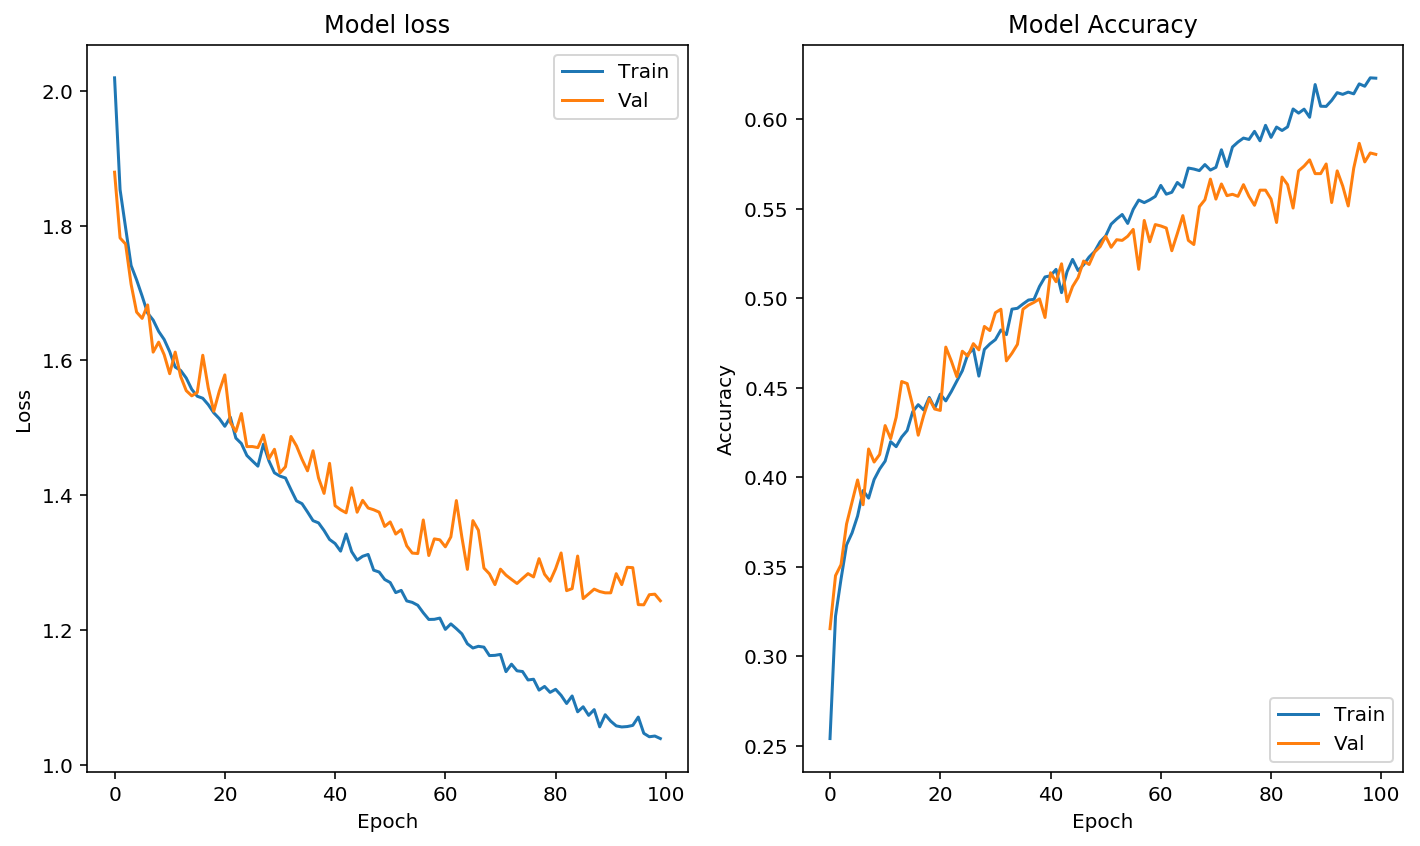

In [222]:
loss_accuracy_plot(bi_lstm_hist3)

In [224]:
bi_lstm4 = bidirectional_lstm(h_units1 = 32, h_units2 = 16, shape_input = X_train.shape[1:], activation_f = 'tanh', dropout1=0.3, dropout2=0.3, learning_rate=0.001)
bi_lstm_hist4 = bi_lstm4.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

Train on 10399 samples, validate on 2600 samples
Epoch 1/100
10399/10399 [==============================] - 92s 9ms/step - loss: 2.0669 - acc: 0.2414 - val_loss: 1.9391 - val_acc: 0.2804
Epoch 2/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.8945 - acc: 0.3078 - val_loss: 1.8303 - val_acc: 0.3335
Epoch 3/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.8373 - acc: 0.3364 - val_loss: 1.7938 - val_acc: 0.3492
Epoch 4/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.7929 - acc: 0.3516 - val_loss: 1.7776 - val_acc: 0.3488
Epoch 5/100
10399/10399 [==============================] - 81s 8ms/step - loss: 1.7769 - acc: 0.3525 - val_loss: 1.7265 - val_acc: 0.3685
Epoch 6/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.7498 - acc: 0.3636 - val_loss: 1.6911 - val_acc: 0.3865
Epoch 7/100
10399/10399 [==============================] - 80s 8ms/step - loss: 1.7263 - acc: 0.3754 - val_loss: 1.6971 - v

Changing the activation function appears to have the biggest impact here - sigmoid to tanh. The maximum accuracy score achieved is 0.59 and the train, validation, and test scores have little variance between them. Of these four models, I would select model 3 because it gives the highest validation/test score and according to the plots, the most stable performance.

# **Analysis**

In [225]:
from sklearn.metrics import confusion_matrix, classification_report
import scikitplot as skplt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [226]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [227]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

In [255]:
y_test_inv = np.ravel(onehot.inverse_transform(y_test))

label = LabelEncoder()
y_label = label.fit_transform(y).reshape(-1, 1)

composers = ['bach', 'beethoven', 'brahms', 'chopin', 'debussy', 'haydn', 'liszt', 'mozart', 'scarlatti', 'tchaikovsky']

In [264]:
pred = label.inverse_transform(bi_lstm3.predict_classes(X_test).reshape(-1, 1))
pred_prob = bi_lstm3.predict(X_test)

In [256]:
print(classification_report(y_test_inv, pred, labels=composers))

              precision    recall  f1-score   support

        bach       0.68      0.71      0.69       242
   beethoven       0.56      0.54      0.55       565
      brahms       0.59      0.56      0.58       187
      chopin       0.57      0.71      0.63       400
     debussy       0.52      0.31      0.39       162
       haydn       0.63      0.71      0.67       635
       liszt       0.57      0.53      0.55       354
      mozart       0.52      0.56      0.54       414
   scarlatti       0.64      0.49      0.56       210
 tchaikovsky       0.50      0.12      0.20        81

   micro avg       0.59      0.59      0.59      3250
   macro avg       0.58      0.53      0.54      3250
weighted avg       0.58      0.59      0.58      3250



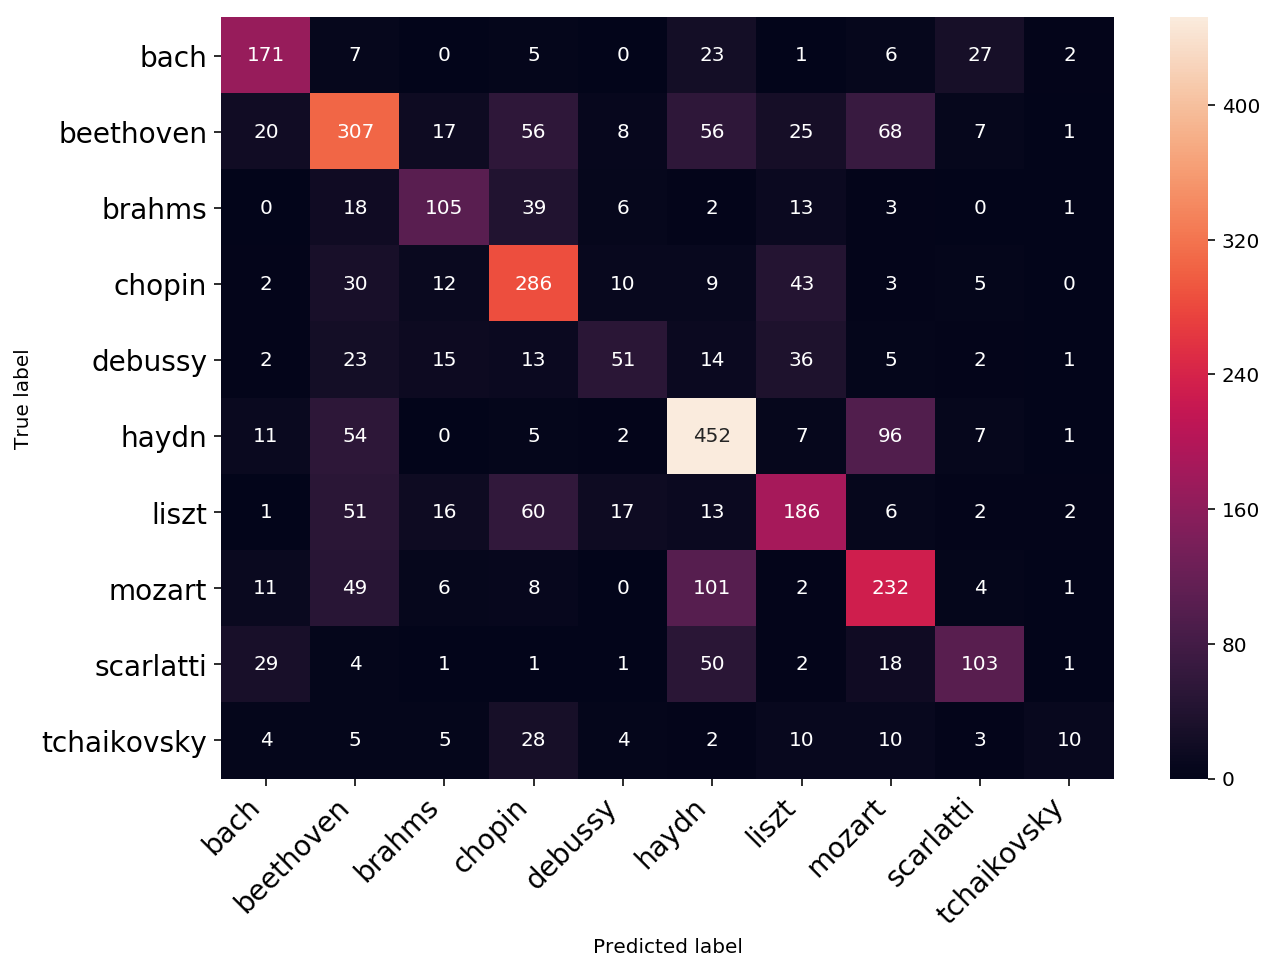

In [259]:
confusion_mat = confusion_matrix(y_test_inv, pred)
print_confusion_matrix(confusion_mat, composers, figsize = (10,7), fontsize=14);

The confusion matrix makes less sense than the matrix for the spectral features, at least from a musical perspective. Composers that have the most data seem to have the highest number of true positives, where as composers like Debussy and Tchaikovsky probably do not have enough data to train the LSTM model on. However, there are still some parts of the matrix that do make a lot of sense, Haydn and Mozart are most oftenly 'confused' and similarly with Chopin and Liszt. This, along with the accuracy score of the model is somewhat staggering considering there is no other context to the sequence of notes, apart from the notes themselves. For example, when you consider a big part of music from the Classical era is 'floating' off the keys at the end of the phrase, which would be apparent if you were to listen to music from this era, it's amazing that it was able to predict as many as it did correctly for Mozart and Haydn. 

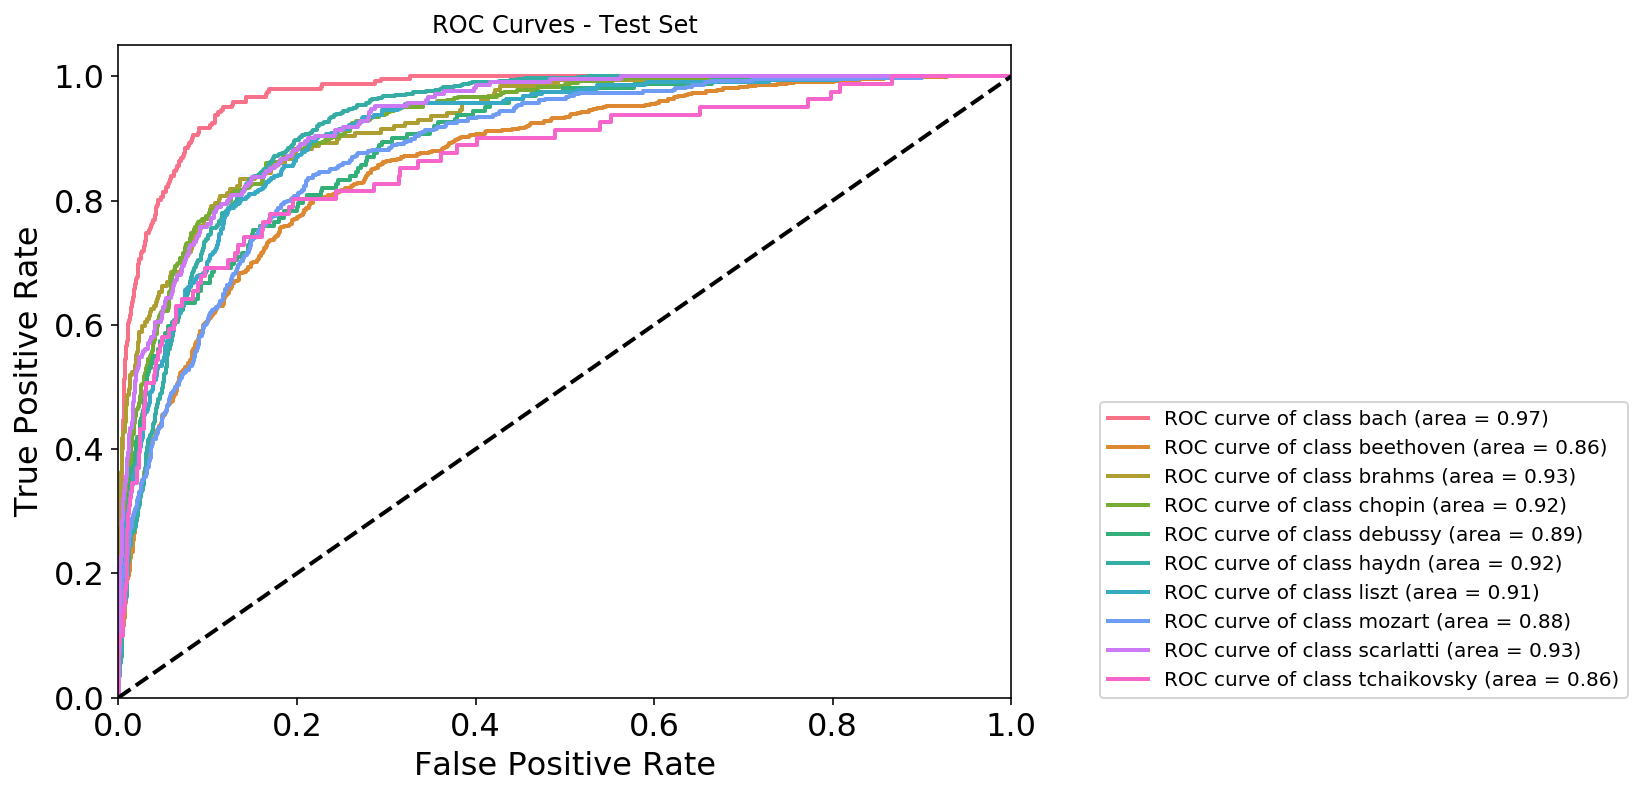

In [265]:
cmap = ListedColormap(sns.color_palette("husl",10))

skplt.metrics.plot_roc(y_test_inv, pred_prob, plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.legend(loc=[1.1,0])

plt.title('ROC Curves - Test Set')

plt.show()

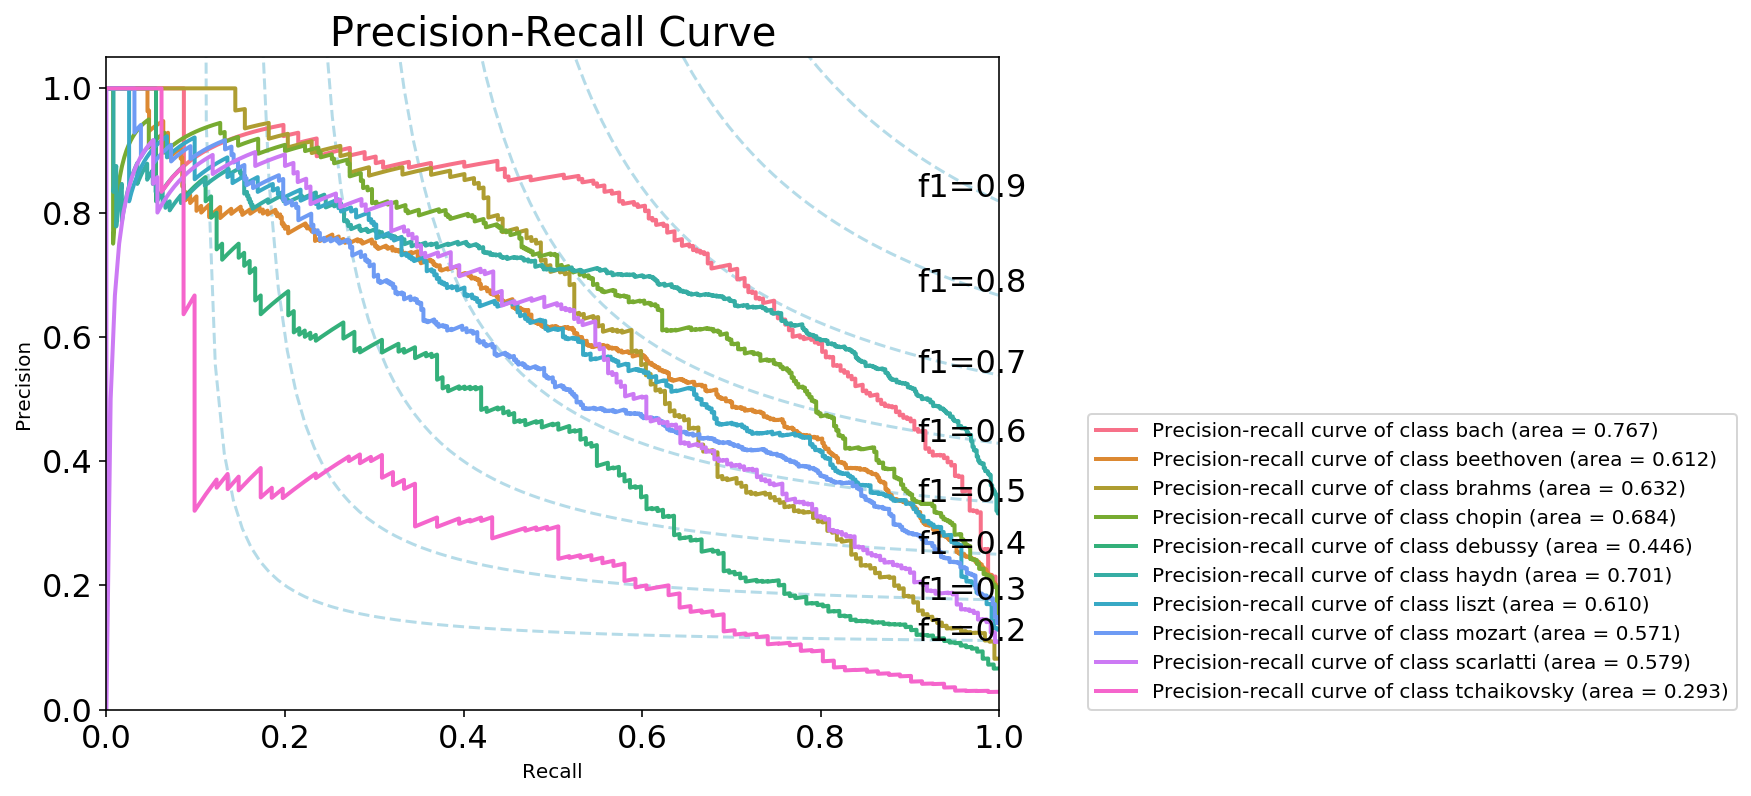

In [266]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test_inv, pred_prob,
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()